In [2]:
import pandas as pd
import numpy as np
import random
import itertools
from matplotlib import pyplot as plt
import scipy.spatial as ss

### Below I download the preprocessed data

In [3]:
features = pd.read_csv("https://media.githubusercontent.com/media/vbyno/keystroke_dynamics/master/data/df_all_mfqn.csv",
                          index_col = 0,
                          dtype = {'time': np.int32})

print(features.head())

/Users/ruska/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


                 user_id  time task_name codes_letters
0  A002160837SWJFPIAI7L7    77    copy_1       S_space
1  A002160837SWJFPIAI7L7    65    copy_1       S_space
2  A002160837SWJFPIAI7L7    94    copy_1       D_space
3  A002160837SWJFPIAI7L7   133    copy_1       E_space
4  A002160837SWJFPIAI7L7   201    copy_1       space_T


### Below the two functions to vizualize our data

In [137]:
def plot_user_stroke_by_tasks(df, user, stroke):
    user_stroke_df = df[df['user_id']==user][df['codes_letters'] == stroke]
    
    fig, axs = plt.subplots(3, 2, figsize=(12,12))
    i=1
    tasks_dict = {}
    for task in user_stroke_df['task_name'].unique():
        time = user_stroke_df[user_stroke_df['task_name'] == task]['time']
        tasks_dict[str(task)] = time


    x = user_stroke_df['task_name'].unique()

    tasks_combinations_tuples = list(itertools.combinations(x,2))
    tasks_combinations_list = [list(elem) for elem in tasks_combinations_tuples]
    title = "user: " + user + ", stroke: " + stroke

    for comb in tasks_combinations_list:
        row = (i//2+i%2)-1
        col = 0 if (i+2)%2 == 1 else 1
        axs[row, col].hist([tasks_dict[comb[0]], tasks_dict[comb[1]]], label=[comb[0], comb[1]], normed=True)
        axs[row,col].legend()
        axs[row,col].set_title(title)
        i+=1
    plt.show()

In [138]:
def plot_stroke_two_users_by_task(df, user1, user2, stroke):
    fig, axs = plt.subplots(2, 2, figsize=(10,8))
    i=1
    user1_stroke_df = df[df['user_id']==user1][df['codes_letters'] == stroke]
    user2_stroke_df = df[df['user_id']==user2][df['codes_letters'] == stroke]
    title = stroke
    for task in user1_stroke_df['task_name'].unique():
        user1_task = user1_stroke_df[user1_stroke_df['task_name'] == task]['time']
        user2_task = user2_stroke_df[user2_stroke_df['task_name'] == task]['time']
        name1 = user1 + " " + str(task)
        name2 = user2 + " " + str(task)
        row = (i//2+i%2)-1
        col = 0 if (i+2)%2 == 1 else 1
        axs[row, col].hist([user1_task, user2_task], label=[name1, name2], normed=True, bins = 15)
        axs[row,col].legend()
        axs[row,col].set_title(title)
        i+=1
    plt.show()

### To have some sense of the data, let's plot a digraph distribution of a user by tasks:
A user was selected randomly. T_H is one of the most popular digraphs. The histograms show flight times (see our paper) and their frequencies. The most severe outliers have been removed at the preprocessing stage.

/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


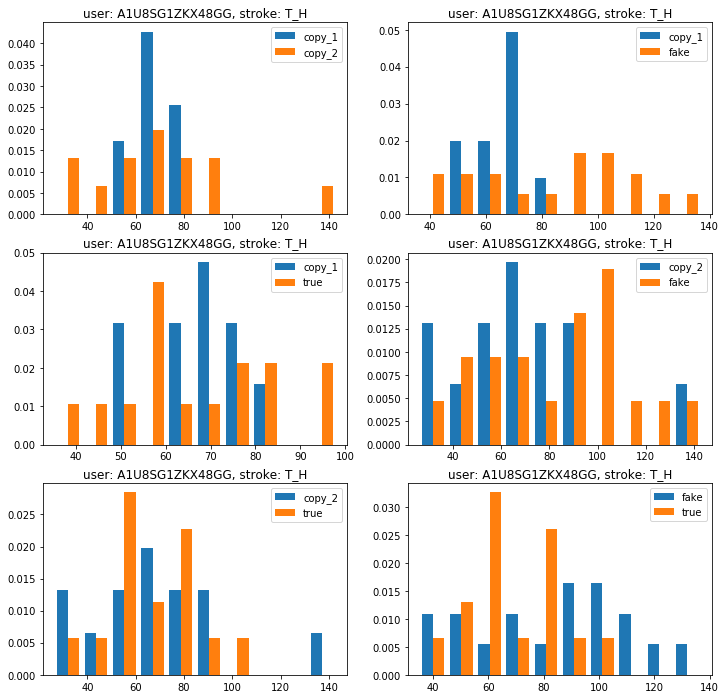

In [139]:
plot_user_stroke_by_tasks(features, 'A1U8SG1ZKX48GG','T_H')

###  And now let's plot side-by-side distributions of the same digraph for two different users
Here we show side-by-side distributions of timings for keystroke H_E of two different randomly selected users. The main idea of the graph - the timings are different and statistical (data mining) methods will likely help to differentiate among the users.

/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


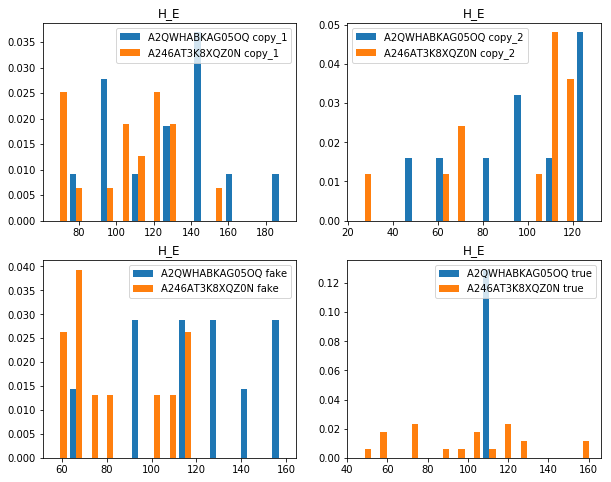

In [140]:
plot_stroke_two_users_by_task(features, 'A2QWHABKAG05OQ', 'A246AT3K8XQZ0N', 'H_E')

### Bellow we randomly select 3 subsets of subjects: 20, 50 and 100. I can not run the algorithm on all subjects, as code optimization is needed. The algorithms takes over 30 minutes to run for 100 users

In [141]:
df = features
random.seed(3)
test_users_20 = random.choices(df['user_id'].unique(), k=20)

In [142]:
df = features
random.seed(3)
test_users_50 = random.choices(df['user_id'].unique(), k=50)

In [143]:
df = features
random.seed(3)
test_users_100 = random.choices(df['user_id'].unique(), k=100)

In [144]:
df = features
df_100 = df[df['user_id'].isin(test_users_100)]

In [145]:
df = features
df_50 = df[df['user_id'].isin(test_users_50)]

In [146]:
df = features
df_20 = df[df['user_id'].isin(test_users_20)]

In [147]:
most_frequent_digraphs = ['S_space', 'space_A', 'D_space', 'E_space', 'space_T', 'backspace_backspace',
                          'T_H', 'H_E', 'A_N', 'T_space', 'R_E', 'I_N']

most_frequent_letters = ['E','A','R','I','O','T','N','S', 'space']

In [148]:
most_fqnt = most_frequent_digraphs + most_frequent_letters
print(most_fqnt)

['S_space', 'space_A', 'D_space', 'E_space', 'space_T', 'backspace_backspace', 'T_H', 'H_E', 'A_N', 'T_space', 'R_E', 'I_N', 'E', 'A', 'R', 'I', 'O', 'T', 'N', 'S', 'space']


In [149]:
def get_feature_vector(df, user, task, mfl):
    features_df = df[df['user_id'] == user][df['task_name'] == task].loc[:, ['codes_letters', 'time']]
    features_df = features_df.sort_values(by='codes_letters')
    features_df_grouped = features_df.groupby('codes_letters')['time'].apply(list)
    x = features_df_grouped
    diff = [xi for xi in mfl if xi not in x.index.tolist()]
    if len(diff) > 0:
        for strk in diff:
            x.loc[strk] = [np.nan]
            
        x.sort_index(inplace=True)
    length = max(map(len, x))
    y=np.array([xi+[np.nan]*(length-len(xi)) for xi in x])
    return y

In [150]:
def get_user_task_mean_std(df, user, task, func, mfl):
    df = df[df['user_id'] == user][df['task_name'] == task]
    df_grouped_mean = df[['user_id', 'task_name', 'codes_letters', 'time']].groupby(['codes_letters']).agg([func])
    x = df_grouped_mean
    diff = [xi for xi in mfl if xi not in x.index.tolist()]
    if len(diff) > 0:
        for strk in diff:
            x.loc[strk] = np.nan
        x.sort_index(inplace=True)
    stat = x.values
    return stat

### HERE ARE THE MODEL

In [151]:
def zscore_model(df, test_users):
    result_dict = {}
    keytask = 'copy_1'
    accuracy = []
    true_predicted_pairs = {}

    f_cache = {}
    tasks_in_f_cache = {}

    for keyuser in test_users:
        true_user = (keyuser, keytask)

        df_nu = df.loc[~((df['user_id']==keyuser)&(df['task_name']==keytask)),:]
        means = get_user_task_mean_std(df, keyuser, keytask, 'mean', most_fqnt)
        stds = get_user_task_mean_std(df, keyuser, keytask, 'std', most_fqnt)
        #print(means)

        for user in df_nu['user_id'].unique():
            for task in df_nu['task_name'].unique():

                f = get_feature_vector(df_nu, user, task, most_fqnt)
                #tasks_in_f_cache[task] = f
                #f_cache[user]=tasks_in_f_cache

                r = abs(f-means)/stds
                th = 1.96
                notnans_by_row = (~np.isnan(r)).sum(axis=1)
                za = (r < th).sum(axis = 1)
                result = za/notnans_by_row
                result_shape = result.reshape((1, result.shape[0]))
                ones = np.ones((1, result.shape[0]))
                d = ss.distance.cdist(ones, result_shape, metric='euclidean')[0][0]

                result_dict[(user, task)] = d     

        result_user = min(result_dict, key=result_dict.get)
        true_predicted_pairs[(keyuser, keytask)] = result_user
        if result_user[0] == keyuser:
            accuracy.append(1)
        else:
            accuracy.append(0)
    print('The accuracy is:')
    print(sum(accuracy)/len(accuracy))
    print('The pairs of true/predicted users:')
    print(true_predicted_pairs)
    return true_predicted_pairs

## For a subset of 20 users
We see that the algorithm corecctly recognized 80% of the users. The pairs are printed out.

In [152]:
zscore_model(df_20, test_users_20)

/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in less
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide


The accuracy is:
0.8
The pairs of true/predicted users:
{('A2QWHABKAG05OQ', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_2'), ('A1M72TTFPE00AM', 'copy_1'): ('A1M72TTFPE00AM', 'fake'), ('A5A9QE4W8X1UI', 'copy_1'): ('A246AT3K8XQZ0N', 'copy_2'), ('ABSEC3N730H1Q', 'copy_1'): ('ABSEC3N730H1Q', 'fake'), ('A1F6NOYLVNUA9A', 'copy_1'): ('A1F6NOYLVNUA9A', 'copy_2'), ('A1HPNJ1H0A32AC', 'copy_1'): ('A1HPNJ1H0A32AC', 'copy_2'), ('A12E72AAMBWN9O', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'), ('A34P5NWNC6MZNO', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_1'), ('A2XAMU363TRW9B', 'copy_1'): ('A2P9WEY7VI3PBM', 'copy_2'), ('A2Q1C7AXB3U84W', 'copy_1'): ('A2Q1C7AXB3U84W', 'copy_2'), ('APQ5FYQDBUVPZ', 'copy_1'): ('APQ5FYQDBUVPZ', 'copy_2'), ('a2k498842rv6et', 'copy_1'): ('a2k498842rv6et', 'fake'), ('A32Z0AHWWLRGG2', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'), ('A1E7X1N39B8IQ6', 'copy_1'): ('A1E7X1N39B8IQ6', 'true'), ('A23D6RFE7YPFEI', 'copy_1'): ('A23D6RFE7YPFEI', 'copy_2'), ('A246AT3K8XQZ0N', 'copy_1'): ('A246AT3K8XQZ0N', 'copy_2

{('A2QWHABKAG05OQ', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_2'),
 ('A1M72TTFPE00AM', 'copy_1'): ('A1M72TTFPE00AM', 'fake'),
 ('A5A9QE4W8X1UI', 'copy_1'): ('A246AT3K8XQZ0N', 'copy_2'),
 ('ABSEC3N730H1Q', 'copy_1'): ('ABSEC3N730H1Q', 'fake'),
 ('A1F6NOYLVNUA9A', 'copy_1'): ('A1F6NOYLVNUA9A', 'copy_2'),
 ('A1HPNJ1H0A32AC', 'copy_1'): ('A1HPNJ1H0A32AC', 'copy_2'),
 ('A12E72AAMBWN9O', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'),
 ('A34P5NWNC6MZNO', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_1'),
 ('A2XAMU363TRW9B', 'copy_1'): ('A2P9WEY7VI3PBM', 'copy_2'),
 ('A2Q1C7AXB3U84W', 'copy_1'): ('A2Q1C7AXB3U84W', 'copy_2'),
 ('APQ5FYQDBUVPZ', 'copy_1'): ('APQ5FYQDBUVPZ', 'copy_2'),
 ('a2k498842rv6et', 'copy_1'): ('a2k498842rv6et', 'fake'),
 ('A32Z0AHWWLRGG2', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'),
 ('A1E7X1N39B8IQ6', 'copy_1'): ('A1E7X1N39B8IQ6', 'true'),
 ('A23D6RFE7YPFEI', 'copy_1'): ('A23D6RFE7YPFEI', 'copy_2'),
 ('A246AT3K8XQZ0N', 'copy_1'): ('A246AT3K8XQZ0N', 'copy_2'),
 ('A1VEDWR7HK6T42', 'copy_1'): ('A1VE

## For a subset of 50 users (runs 6 minutes):

We see that the accuracy drops to 68%. 

In [158]:
zscore_model(df_50, test_users_50)

/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in less
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide


The accuracy is:
0.68
The pairs of true/predicted users:
{('A2QWHABKAG05OQ', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_2'), ('A1M72TTFPE00AM', 'copy_1'): ('A1M72TTFPE00AM', 'fake'), ('A5A9QE4W8X1UI', 'copy_1'): ('A246AT3K8XQZ0N', 'copy_2'), ('ABSEC3N730H1Q', 'copy_1'): ('ASV3VVYVR8OTZ', 'copy_2'), ('A1F6NOYLVNUA9A', 'copy_1'): ('A3CQM7CBFNIHGR', 'copy_2'), ('A1HPNJ1H0A32AC', 'copy_1'): ('A1HPNJ1H0A32AC', 'copy_2'), ('A12E72AAMBWN9O', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'), ('A34P5NWNC6MZNO', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_1'), ('A2XAMU363TRW9B', 'copy_1'): ('A2P9WEY7VI3PBM', 'copy_2'), ('A2Q1C7AXB3U84W', 'copy_1'): ('A2Q1C7AXB3U84W', 'copy_2'), ('APQ5FYQDBUVPZ', 'copy_1'): ('APQ5FYQDBUVPZ', 'copy_2'), ('a2k498842rv6et', 'copy_1'): ('a2k498842rv6et', 'fake'), ('A32Z0AHWWLRGG2', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'), ('A1E7X1N39B8IQ6', 'copy_1'): ('A1E7X1N39B8IQ6', 'true'), ('A23D6RFE7YPFEI', 'copy_1'): ('A23D6RFE7YPFEI', 'copy_2'), ('A246AT3K8XQZ0N', 'copy_1'): ('A246AT3K8XQZ0N', 'cop

{('A2QWHABKAG05OQ', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_2'),
 ('A1M72TTFPE00AM', 'copy_1'): ('A1M72TTFPE00AM', 'fake'),
 ('A5A9QE4W8X1UI', 'copy_1'): ('A246AT3K8XQZ0N', 'copy_2'),
 ('ABSEC3N730H1Q', 'copy_1'): ('ASV3VVYVR8OTZ', 'copy_2'),
 ('A1F6NOYLVNUA9A', 'copy_1'): ('A3CQM7CBFNIHGR', 'copy_2'),
 ('A1HPNJ1H0A32AC', 'copy_1'): ('A1HPNJ1H0A32AC', 'copy_2'),
 ('A12E72AAMBWN9O', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'),
 ('A34P5NWNC6MZNO', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_1'),
 ('A2XAMU363TRW9B', 'copy_1'): ('A2P9WEY7VI3PBM', 'copy_2'),
 ('A2Q1C7AXB3U84W', 'copy_1'): ('A2Q1C7AXB3U84W', 'copy_2'),
 ('APQ5FYQDBUVPZ', 'copy_1'): ('APQ5FYQDBUVPZ', 'copy_2'),
 ('a2k498842rv6et', 'copy_1'): ('a2k498842rv6et', 'fake'),
 ('A32Z0AHWWLRGG2', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'),
 ('A1E7X1N39B8IQ6', 'copy_1'): ('A1E7X1N39B8IQ6', 'true'),
 ('A23D6RFE7YPFEI', 'copy_1'): ('A23D6RFE7YPFEI', 'copy_2'),
 ('A246AT3K8XQZ0N', 'copy_1'): ('A246AT3K8XQZ0N', 'copy_2'),
 ('A1VEDWR7HK6T42', 'copy_1'): ('A1

## For a subset of 100 users (runs 35 minutes):

We see that the accuracy is getting more lower - to 57%.

In [164]:
true_predicted_pairs = zscore_model(df_100, test_users_100)


/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in less
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in true_divide
/Users/ruska/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in true_divide


The accuracy is:
0.57
The pairs of true/predicted users:
{('A2QWHABKAG05OQ', 'copy_1'): ('A2QWHABKAG05OQ', 'copy_2'), ('A1M72TTFPE00AM', 'copy_1'): ('A1M72TTFPE00AM', 'fake'), ('A5A9QE4W8X1UI', 'copy_1'): ('A3K1AH7Y7YIVJD', 'true'), ('ABSEC3N730H1Q', 'copy_1'): ('ASV3VVYVR8OTZ', 'copy_2'), ('A1F6NOYLVNUA9A', 'copy_1'): ('A1S3RXZEBY0AW7', 'copy_2'), ('A1HPNJ1H0A32AC', 'copy_1'): ('A1HPNJ1H0A32AC', 'copy_2'), ('A12E72AAMBWN9O', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'), ('A34P5NWNC6MZNO', 'copy_1'): ('ASLCXPPN9SV69', 'copy_1'), ('A2XAMU363TRW9B', 'copy_1'): ('A2P9WEY7VI3PBM', 'copy_2'), ('A2Q1C7AXB3U84W', 'copy_1'): ('A2Q1C7AXB3U84W', 'copy_2'), ('APQ5FYQDBUVPZ', 'copy_1'): ('APQ5FYQDBUVPZ', 'copy_2'), ('a2k498842rv6et', 'copy_1'): ('a2k498842rv6et', 'fake'), ('A32Z0AHWWLRGG2', 'copy_1'): ('A12E72AAMBWN9O', 'copy_1'), ('A1E7X1N39B8IQ6', 'copy_1'): ('A1E7X1N39B8IQ6', 'true'), ('A23D6RFE7YPFEI', 'copy_1'): ('A23D6RFE7YPFEI', 'copy_2'), ('A246AT3K8XQZ0N', 'copy_1'): ('A246AT3K8XQZ0N', 'copy_2

# Here I count shares of different tasks that were used to corretly predict a user. Copy 2 takes the largest share

In [156]:
for k,v in true_predicted_pairs.items():
    if k[0] == v[0]:
        print(k,v)

In [166]:
i= 0
c2 = 0
t=0
f=0
for k,v in true_predicted_pairs.items():
    if k[0] == v[0]:
        i += 1
        if v[1] == 'copy_2':
            c2 += 1
        if v[1] == 'true':
            t += 1
        if v[1] == 'fake':
            f += 1
print('Share of copy2')           
print(c2/i)
print('Share of true') 
print(t/i)
print('Share of false') 
print(f/i)

Share of copy2
0.5961538461538461
Share of true
0.17307692307692307
Share of false
0.21153846153846154
